<a href="https://colab.research.google.com/github/rymuelle/CFB_pytorch_toy_minimizer/blob/master/lstm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This follows https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/, and is just an example of an lstm.

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.get_dataset_names()

/usr/local/lib/python3.6/dist-packages/seaborn/utils.py:384: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file /usr/local/lib/python3.6/dist-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [4]:
flight_data.shape

(144, 3)

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

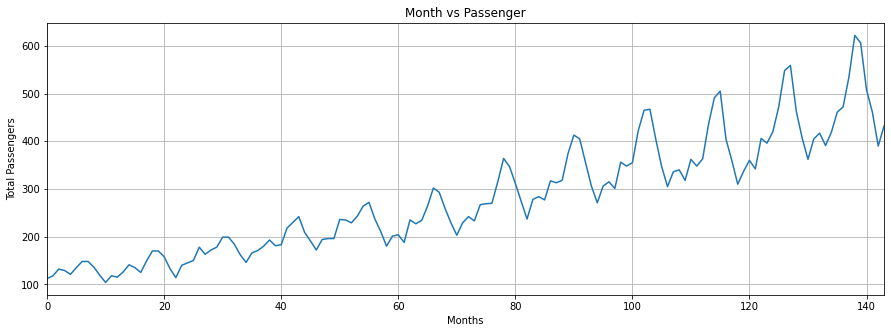

In [6]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [7]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)


[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [8]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
print(train_data_normalized[:5])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]


So far, we've just gotten the data and normalized it. Now we are going to actually start doing torch stuff. First, we convert data to a tensor.

In [10]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

Now, we convert our data into sequences and labels. The training window is 12, since we have monthly data.

In [11]:
train_window = 12


In [12]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [13]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

Now we have an array of sequences of 12 length with the next value, starting at 0, then 1, then 2 ... indecies.

Now, we will swdinw oue model:

In [14]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size=hidden_layer_size

    self.lstm=nn.LSTM(input_size,hidden_layer_size)

    self.linear=nn.Linear(hidden_layer_size,output_size)

    self.hidden_cell=(torch.zeros(1,1,self.hidden_layer_size),
                      torch.zeros(1,1,hidden_layer_size))
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1),
                                           self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq),-1))
    return predictions[-1]

In [15]:
model=LSTM()
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [17]:
epochs=150

for i in range(epochs):
  for seq, labels in train_inout_seq:
    optimizer.zero_grad()
    model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size),
                       torch.zeros(1,1,model.hidden_layer_size))
    y_pred = model(seq)
    single_loss=loss_function(y_pred,labels)
    single_loss.backward()
    optimizer.step()
  if i%25==1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03645076
epoch:  26 loss: 0.00696933
epoch:  51 loss: 0.00006054
epoch:  76 loss: 0.01282137
epoch: 101 loss: 0.00208967
epoch: 126 loss: 0.00000000
epoch: 149 loss: 0.0073790420


Now, we make future predictions.

In [18]:
fut_pred=12
test_inputs=train_data_normalized[-train_window:].tolist()
test_inputs

[0.12527473270893097,
 0.04615384712815285,
 0.3274725377559662,
 0.2835164964199066,
 0.3890109956264496,
 0.6175824403762817,
 0.9516483545303345,
 1.0,
 0.5780220031738281,
 0.33186814188957214,
 0.13406594097614288,
 0.32307693362236023]

make prediction

In [19]:
model.eval()

for i in range(fut_pred):
  seq=torch.FloatTensor(test_inputs[-train_window:])
  with torch.no_grad():
    model.hidden=(torch.zeros(1,1, model.hidden_layer_size),
                  torch.zeros(1,1,model.hidden_layer_size))
    test_inputs.append(model(seq).item())
test_inputs[fut_pred:]

[0.3889837861061096,
 0.4836583137512207,
 0.5069672465324402,
 0.6610338091850281,
 0.6598962545394897,
 0.6657671928405762,
 0.8845106959342957,
 0.7613509297370911,
 1.0347633361816406,
 0.8668332695960999,
 1.070805311203003,
 1.131957769393921]

un-normalize

In [20]:
actual_predictions=scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
actual_predictions

array([[419.99381134],
       [441.53226638],
       [446.83504859],
       [481.88519159],
       [481.62639791],
       [482.96203637],
       [532.72618333],
       [504.70733652],
       [566.90865898],
       [528.70456883],
       [575.1082083 ],
       [589.02039254]])

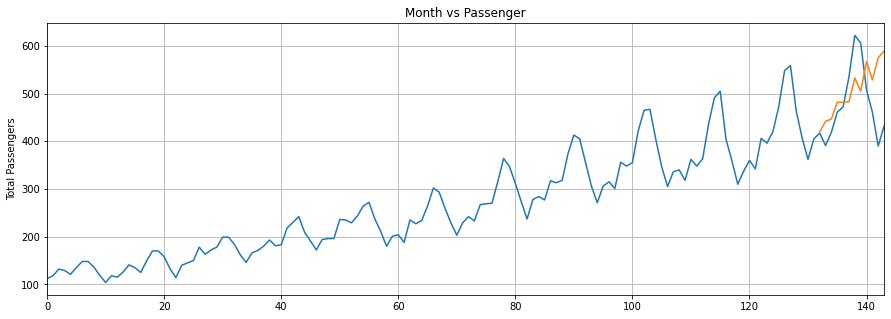

In [21]:
x=np.arange(132,144,1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()